In [ ]:
! pip install kaggle    # Install the Kaggle library

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle        # Make a directory named “.kaggle”

In [ ]:
! cp kaggle.json ~/.kaggle/         # Copy the “kaggle.json” into this new directory

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json        # Allocate the required permission for this file.

In [ ]:
! kaggle competitions download dogs-vs-cats

 99% 802M/812M [00:03<00:00, 274MB/s]
100% 812M/812M [00:03<00:00, 232MB/s]


In [ ]:
! unzip dogs-vs-cats

Archive:  dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [ ]:
! unzip train
! unzip  test1

Streaming output truncated to the last 5000 lines.
  inflating: test1/5499.jpg          
  inflating: test1/55.jpg            
  inflating: test1/550.jpg           
  inflating: test1/5500.jpg          
  inflating: test1/5501.jpg          
  inflating: test1/5502.jpg          
  inflating: test1/5503.jpg          
  inflating: test1/5504.jpg          
  inflating: test1/5505.jpg          
  inflating: test1/5506.jpg          
  inflating: test1/5507.jpg          
  inflating: test1/5508.jpg          
  inflating: test1/5509.jpg          
  inflating: test1/551.jpg           
  inflating: test1/5510.jpg          
  inflating: test1/5511.jpg          
  inflating: test1/5512.jpg          
  inflating: test1/5513.jpg          
  inflating: test1/5514.jpg          
  inflating: test1/5515.jpg          
  inflating: test1/5516.jpg          
  inflating: test1/5517.jpg          
  inflating: test1/5518.jpg          
  inflating: test1/5519.jpg          
  inflating: test1/552.jpg           

In [ ]:
from zipfile import ZipFile
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil

In [ ]:
def extract_file(dir):
    '''
    This function for extracting the files.
    INPUT:
    dir: str. The main file direction.
    OUTPUT:
    Extracted files.
    '''

    with ZipFile(dir, r) as zip:
      zip.extractall()

def copy_files(rng, path1, name, path2):
    '''
    This function for copying the files from the source to destination.
    INPUT:
    rng: list . A list that contains the ranges.
    path1: str. The data directory.
    name: str. The animal name.
    path2: str. The destination directory
    '''
    fnames = [f'{name}.{idx}.jpg' for idx in range(rng[0],rng[1])]

    for fname in fnames:
      src = os.path.join(path1, fname)
      dst = os.path.join(path2, fname)
      shutil.copyfile(src, dst)

In [ ]:
# The main path
path = '/content/'

# Training directory
train_dir = os.path.join(path,'Train')
os.mkdir(train_dir)

# Validation directory
val_dir = os.path.join(path,'Val')
os.mkdir(val_dir)

# Cats training directory
train_cats_dir = os.path.join(train_dir,'cats')
os.mkdir(train_cats_dir)

# Cats validation directory
val_cats_dir = os.path.join(val_dir,'cats')
os.mkdir(val_cats_dir)

# Dogs training directory
train_dogs_dir = os.path.join(train_dir,'dogs')
os.mkdir(train_dogs_dir)

# Dogs validation directory
val_dogs_dir = os.path.join(val_dir,'dogs')
os.mkdir(val_dogs_dir)


# Copying training cats and dogs files
copy_files([0,10000],os.path.join(path,'train'),'cat',train_cats_dir)
copy_files([0,10000],os.path.join(path,'train'),'dog',train_dogs_dir)

# Copying validation cats and dogs files
copy_files([10000,12500],os.path.join(path,'train'),'cat',val_cats_dir)
copy_files([10000,12500],os.path.join(path,'train'),'dog',val_dogs_dir)

# Display message
print('Preparing the data directories is done')

Preparing the data directories is done


In [ ]:
train_data = ImageDataGenerator(rescale=1/255)
validation_data = ImageDataGenerator(rescale=1/255)

train_generator = train_data.flow_from_directory(directory=train_dir,
                               target_size = (128,128),
                               batch_size=20,
                               class_mode='binary')

validate_generator = validation_data.flow_from_directory(directory=val_dir,
                               target_size = (128,128),
                               batch_size=20,
                               class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [ ]:
# The CNN architecture
def create_model():
  model = keras.Sequential()
  model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape = (128,128,3)))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Conv2D(64,(3,3),activation='relu'))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Conv2D(64,(3,3),activation='relu'))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(512,activation='relu'))
  model.add(layers.Dense(1,activation='sigmoid'))


  model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
    )
  
  return model

In [ ]:
tf.keras.backend.clear_session()
# Create a model instance
model = create_model()

# Display the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [ ]:

checkpoint_filepath = '/content/checkpoint'

# Create a callback that saves the model's weights
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=False)

# if we change save_freq other than epoch, We can set save_weights_only=True and save weights
# in each epochs and later for loading the weight we load 
# latest seved weight with tf.train.latest_checkpoint(checkpoint_dir) and then 
# use model.load_weights(checkpoint_path) to apply loaded weight on model
# if we keep save_freq to default value, we just use model.load_weights(checkpoint_path)

# if we want to stop training and resume later, we can save model and set save_best_only=False to save all epochs and later 
# by loading and fitting model we can resume training and also plot accuracy and losses for saved model before and after stoping training
# for loading model use keras.models.load_model('/content/checkpoint')

# Train the model
history = model.fit(train_generator,steps_per_epoch=1000, epochs=10,
                    validation_data=validate_generator,validation_steps=250,verbose=1,
                    callbacks=[model_checkpoint_callback])

Epoch 1/10
1000/1000 [==============================] - ETA: 0s - loss: 0.5940 - accuracy: 0.6727

1000/1000 [==============================] - 658s 657ms/step - loss: 0.5940 - accuracy: 0.6727 - val_loss: 0.4895 - val_accuracy: 0.7580
Epoch 2/10
1000/1000 [==============================] - ETA: 0s - loss: 0.4604 - accuracy: 0.7850

1000/1000 [==============================] - 654s 654ms/step - loss: 0.4604 - accuracy: 0.7850 - val_loss: 0.4270 - val_accuracy: 0.8096
Epoch 3/10
1000/1000 [==============================] - ETA: 0s - loss: 0.3847 - accuracy: 0.8284

1000/1000 [==============================] - 656s 656ms/step - loss: 0.3847 - accuracy: 0.8284 - val_loss: 0.3817 - val_accuracy: 0.8272
Epoch 4/10
1000/1000 [==============================] - ETA: 0s - loss: 0.3162 - accuracy: 0.8612

1000/1000 [==============================] - 652s 652ms/step - loss: 0.3162 - accuracy: 0.8612 - val_loss: 0.4277 - val_accuracy: 0.8264
Epoch 5/10
1000/1000 [==============================] - ETA: 0s - loss: 0.2332 - accuracy: 0.9049

1000/1000 [==============================] - 653s 653ms/step - loss: 0.2332 - accuracy: 0.9049 - val_loss: 0.4085 - val_accuracy: 0.8398
Epoch 6/10
1000/1000 [==============================] - ETA: 0s - loss: 0.1367 - accuracy: 0.9470

1000/1000 [==============================] - 648s 648ms/step - loss: 0.1367 - accuracy: 0.9470 - val_loss: 0.4857 - val_accuracy: 0.8282
Epoch 7/10
 288/1000 [=======>......................] - ETA: 7:08 - loss: 0.0525 - accuracy: 0.9816

In [ ]:
# Loads the model
# history = keras.models.load_model('/content/checkpoint')

# # if we want to resume model after stopping it, use below code
# history = model.fit(train_generator,steps_per_epoch=1000, epochs=10,
#                     validation_data=validate_generator,validation_steps=250,verbose=1,
#                     callbacks=[model_checkpoint_callback])

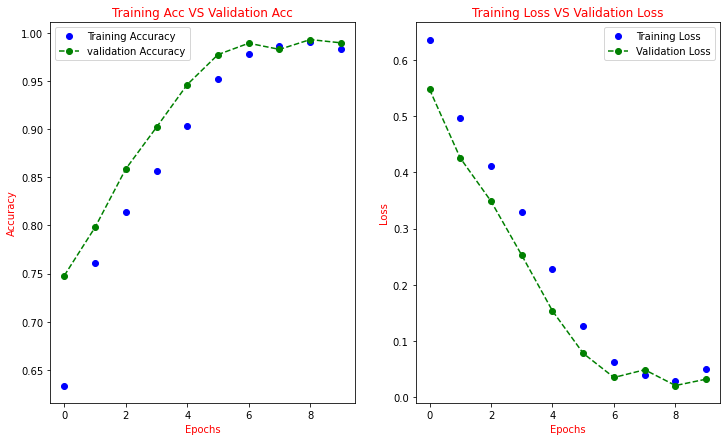

In [ ]:
# Get the results
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(train_acc))

# Plotting the results
fig,axs = plt.subplots(1, 2, figsize=(12,7))
axs[0].plot(epochs, train_acc,'bo', label = 'Training Accuracy')
axs[0].plot(epochs, val_acc,'go--', label = 'validation Accuracy')
axs[0].set_title('Training Acc VS Validation Acc',color='red')
axs[0].set_xlabel('Epochs',color = 'red')
axs[0].set_ylabel('Accuracy',color='red')
axs[0].legend()

axs[1].plot(epochs,train_loss,'bo',label = 'Training Loss')
axs[1].plot(epochs,val_loss,'go--',label = 'Validation Loss')
axs[1].set_title('Training Loss VS Validation Loss',color='red')
axs[1].set_xlabel('Epochs',color = 'red')
axs[1].set_ylabel('Loss',color='red')
axs[1].legend()
plt.show()

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255, rotation_range=30, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1/255)
train_gen = train_datagen.flow_from_directory(train_dir, target_size=(130,130),
                                              batch_size=50, class_mode='binary')
val_gen = val_datagen.flow_from_directory(val_dir,target_size=(130,130),
                                          batch_size=50,class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [ ]:
def create_model_opt():
  # The CNN architecture
  model = keras.Sequential()
  model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape = (130,130,3)))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Conv2D(32,(3,3),activation='relu'))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Conv2D(64,(3,3),activation='relu'))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Conv2D(128,(3,3),activation='relu'))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(512,activation='relu'))
  model.add(layers.Dense(1,activation='sigmoid'))

  # Fitting the model
  model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

  return model


In [ ]:
# The model summary

model_opt = create_model_opt()
model_opt.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 64)      

In [ ]:
checkpoint_filepath = '/content/checkpoint_opt'

# Create a callback that saves the model's weights
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=False)

history = model.fit(train_gen,steps_per_epoch=400,epochs=20,
                    validation_data=val_gen,validation_steps=100,verbose=1,
                    callbacks=[model_checkpoint_callback])

Epoch 1/20
400/400 [==============================] - 656s 2s/step - loss: 0.5521 - accuracy: 0.7406 - val_loss: 0.4467 - val_accuracy: 0.8030
Epoch 2/20
400/400 [==============================] - 657s 2s/step - loss: 0.4544 - accuracy: 0.7865 - val_loss: 0.3790 - val_accuracy: 0.8336
Epoch 3/20
400/400 [==============================] - 655s 2s/step - loss: 0.4415 - accuracy: 0.7955 - val_loss: 0.3569 - val_accuracy: 0.8482
Epoch 4/20
400/400 [==============================] - 650s 2s/step - loss: 0.4226 - accuracy: 0.8047 - val_loss: 0.3400 - val_accuracy: 0.8540
Epoch 5/20
400/400 [==============================] - 648s 2s/step - loss: 0.4062 - accuracy: 0.8166 - val_loss: 0.3480 - val_accuracy: 0.8480
Epoch 6/20
400/400 [==============================] - 648s 2s/step - loss: 0.3915 - accuracy: 0.8204 - val_loss: 0.3777 - val_accuracy: 0.8400
Epoch 7/20
400/400 [==============================] - 647s 2s/step - loss: 0.3836 - accuracy: 0.8235 - val_loss: 0.3459 - val_accuracy: 0.8508

In [ ]:
# Loads the model
# history = keras.models.load_model('/content/checkpoint_opt')

# # if we want to resume model after stopping it, use below code
# history = model.fit(train_generator,steps_per_epoch=1000, epochs=10,
#                     validation_data=validate_generator,validation_steps=250,verbose=1,
#                     callbacks=[model_checkpoint_callback])

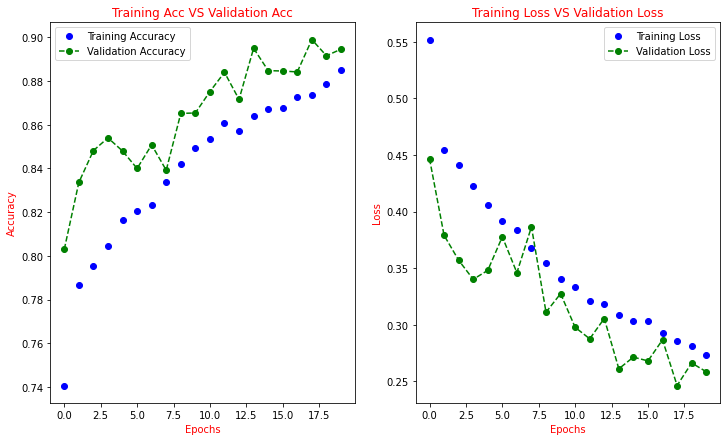

In [ ]:
# Get the results
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(train_acc))

# Plotting the results
fig,axs = plt.subplots(1,2,figsize = (12,7))
axs[0].plot(epochs,train_acc,'bo',label = 'Training Accuracy')
axs[0].plot(epochs,val_acc,'go--',label = 'Validation Accuracy')
axs[0].set_title('Training Acc VS Validation Acc',color='red')
axs[0].set_xlabel('Epochs',color = 'red')
axs[0].set_ylabel('Accuracy',color='red')
axs[0].legend()

axs[1].plot(epochs,train_loss,'bo',label = 'Training Loss')
axs[1].plot(epochs,val_loss,'go--',label = 'Validation Loss')
axs[1].set_title('Training Loss VS Validation Loss',color='red')
axs[1].set_xlabel('Epochs',color = 'red')
axs[1].set_ylabel('Loss',color='red')
axs[1].legend()
plt.show()

In [ ]:
test_dir = '/content/test1'
test_df = pd.DataFraem('filename' : os.listdir(test_dir))
test_datagen = ImageDataGenerator(rescale=1/255)
test_gen = test_datagen.flow_from_dataframe(test_df, test_dir, target_size=(130,130),
                                            batch_size=50, x_col='filename', y_col=None, class_mode=None)


In [ ]:
# The first five rows 
test_df.head()

In [ ]:
# The shape
test_df.shape

In [ ]:
# Return the classes
dict((k,v) for k,v in train_gen.class_indices.items())

In [ ]:
# Get the prediction
pred = model.predict(test_gen,steps=250)

In [ ]:
test_df['Pred'] = np.where(pred > 0.5,1,0)

In [ ]:
test_df.head()

In [ ]:
# Taking a copy
test_copy = test_df.copy()

In [ ]:
test_copy.head()

In [ ]:
test_copy['id'] = test_copy['filename'].str.split('.').str[0]
test_copy['label'] = test_copy['Pred']
test_copy.drop(['Filename','Pred'],axis=1,inplace=True)
test_copy.to_csv('submission.csv',index = False)